In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import numpy as np
import matplotlib.pyplot as plt

import time

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# device = 'cpu'

print(f'device: {device}')

device: cuda:0


In [4]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')

        self.layers = layers
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.H1 = self.linears[0]

        
    'forward pass'
    def forward(self,x,y):              
        
        # for i in range(len(self.layers)-2):
        #     z = self.linears[i](a)
        #     a = self.activation(z)

        a = torch.cat([x,y], dim = 1)    #(N,2)

        for i in range(len(self.layers)-2):
            m = self.linears[i](a)
            a = self.activation(m)


            
        b = self.linears[-1](a) 
         
        return b
    
    def forward_direct(self, x,y):
        
        m = torch.cat([x,y], dim = 1)    #(N,2)    

        W1 = self.linears[0].weight    # (20,2)

        H_x = W1[:, 0].unsqueeze(0)      # (1,20)
        F_x = torch.zeros_like(H_x)

        H_y = W1[:, 1].unsqueeze(0)      # (1,20)
        F_y = torch.zeros_like(H_y)


        

        for i in range(len(self.layers)-2):
            L = self.linears[i](m)            # (N,20)
            m = self.activation(L)            # (N,20)
            m_1 = 1.0-torch.square(m)         # (N,20)

            G_x = m_1*H_x     #\sigma'(L)*H   # (N,20)
            G_y = m_1*H_y
            

            C_x = (-2*m + 2*torch.pow(m,3))*H_x*H_x
            C_y = (-2*m + 2*torch.pow(m,3))*H_y*H_y
          


            E_x = C_x + m_1*F_x    # (N,20)
            E_y = C_y + m_1*F_y    # (N,20)
           


            H_x = torch.matmul(G_x,self.linears[i+1].weight.t())
            F_x = torch.matmul(E_x,self.linears[i+1].weight.t())

            H_y = torch.matmul(G_y,self.linears[i+1].weight.t())
            F_y = torch.matmul(E_y,self.linears[i+1].weight.t())


        m = self.linears[-1](m)
         
        # return z, H_x, H_y, H_t, F_x, F_y, F_t
        return m, H_x, H_y, F_x, F_y


In [5]:
# layers = np.array([2,50,50,50,50,50,1])
layers = np.array([2,20,20,20,20,20,1])
# PINN = Sequentialmodel(layers).to(device)

In [ ]:
# Resetting to ensure the reported peak truly reflects the training loop, rather than including earlier setup.

# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [6]:
# Create the training data

x = torch.linspace(0,1,800).view(-1,1)
y = torch.linspace(0,1,800).view(-1,1)



if torch.is_tensor(x) != True:         
    x = torch.from_numpy(x)  
if torch.is_tensor(y) != True:         
    y = torch.from_numpy(y) 


#convert to float
x = x.float()
y = y.float()


    
x_train,y_train = torch.meshgrid(x.squeeze(),y.squeeze(), indexing = 'xy')

x_train = x_train.reshape(-1,1).to(device)     
y_train = y_train.reshape(-1,1).to(device) 


# x_train = x_train.reshape(-1,1)     
# y_train = y_train.reshape(-1,1) 

     



In [7]:
# Create boundary points

def generate_boundary_points(N = 10000):
    x_0 = torch.zeros(N,1) ; x_1 = torch.ones(N,1); ylr = torch.linspace(0,1.,N).unsqueeze(-1)
    # b_l = torch.cat([x_0,ylr], dim = 1); b_r = torch.cat([x_1,ylr], dim = 1)

    y_0 = torch.zeros(N,1); y_1 = torch.ones(N,1); xbt = torch.linspace(0,1.,N).unsqueeze(-1)
    # b_b = torch.cat([xbt,y_0], dim = 1); b_t = torch.cat([xbt,y_1], dim = 1)

    x_0 = x_0.to(device)
    x_1 = x_1.to(device)
    ylr = ylr.to(device)
    


    y_0 = y_0.to(device)
    y_1 = y_1.to(device)
    xbt = xbt.to(device)

    return x_0, x_1, ylr, y_0, y_1, xbt

In [8]:
def pde_residual(x,y):
    u = PINN(x,y)

    # m, H_x, H_y, F_x, F_y = PINN.forward_direct(x,y,t)
    m, H_x, H_y, F_x, F_y = PINN.forward_direct(x,y)

    du_dx = H_x
    du_dy = H_y
    
    du_dx_x = F_x
    du_dy_y = F_y
    
    

    res_pde = du_dx_x + du_dy_y


    return res_pde

In [9]:
def boundary_condition():

    x_0, x_1, ylr, y_0, y_1, xbt = generate_boundary_points()

    u_x_0 = PINN(x_0, ylr)
    u_x_1 = PINN(x_1, ylr)

    u_y_0 = PINN(xbt,y_0)
    u_y_1 = PINN(xbt,y_1)

   

    res_x_0 = u_x_0 - torch.zeros_like(ylr)
    res_x_1 = u_x_1 - torch.sin(np.pi * ylr)
    res_y_0 = u_y_0 - torch.zeros_like(xbt)
    res_y_1 = u_y_1 - torch.zeros_like(xbt)
    

    return res_x_0,res_x_1,res_y_0,res_y_1

In [10]:
def compute_losses():
   res_pde = pde_residual(x_train, y_train) 
   
   res_x_0,res_x_1,res_y_0,res_y_1 = boundary_condition()

   loss_pde = torch.mean(res_pde**2)
   
   loss_bc = torch.mean(res_x_0**2) + torch.mean(res_x_1**2) + torch.mean(res_y_0**2) + torch.mean(res_y_1**2)

   total_loss = loss_pde + loss_bc

   return total_loss

In [11]:
torch.manual_seed(42)
PINN = Sequentialmodel(layers).to(device)
# PINN = Sequentialmodel(layers)

In [12]:
if device.type == 'cuda':
    torch.cuda.reset_peak_memory_stats(device)

In [13]:
# Using LBFGS

optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.05,max_iter=20,history_size=50,tolerance_grad=1e-9,tolerance_change=1e-9,line_search_fn='strong_wolfe')

max_outer_steps = 15000
threshold = 0.002

start_time = time.time()

loss_history = []
time_history = []

ep = 0


def closure():

    optimizer.zero_grad()
    total_loss = compute_losses()
    total_loss.backward()

    return total_loss

while ep < max_outer_steps:

    total_loss = optimizer.step(closure)

    loss_val = float(total_loss.item())
    loss_history.append(loss_val)
    time_history.append(time.time() - start_time)


    # if total_loss.item() < threshold:
    #     print(f"Reached threshold loss {threshold} at outer step {ep}")
    #     break

    if loss_val < threshold:
        print(f"Reached threshold loss {threshold} at outer step {ep}")
        break



    if ep % 200 == 0:
        # print(f'Outer {ep}, Loss: {total_loss.item()}')
        print(f'Outer {ep}, Loss: {loss_val}')

    ep += 1

elapsed = time.time() - start_time

# print(f"Training stopped at outer step {ep}, total time {time.time() - start_time:.2f} s")

print(f"Training stopped at outer step {ep}, total time {elapsed:.2f} s")

np.save("loss_without_autodiff.npy", np.array(loss_history))
np.save("time_without_autodiff.npy", np.array(time_history))
    

Outer 0, Loss: 0.8004722595214844
Reached threshold loss 0.002 at outer step 22
Training stopped at outer step 22, total time 58.43 s


In [14]:
# Memory usage after training

if device.type == 'cuda':
    peak_mem = torch.cuda.max_memory_allocated(device)
    peak_MB = peak_mem / 1e6
    print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')
    np.save("Lap_peak_mem_without_autodiff.npy", peak_MB)

Peak GPU Memory Usage:  3875.82 MB


In [15]:
import math

def u_closed_form(x, y):
    pi = torch.tensor(math.pi)
    d = torch.sinh(pi)
    sol = (torch.sinh(pi * x) / d) * torch.sin(torch.pi * y)
    return sol

In [16]:
x_test = torch.linspace(0,1,60).view(-1,1)
y_test = torch.linspace(0,1,60).view(-1,1)



# if torch.is_tensor(x_test) != True:         
#     x_test = torch.from_numpy(x_test)  
# if torch.is_tensor(y_test) != True:         
#     y_test = torch.from_numpy(y_test) 


# #convert to float
# x = x_test.float()
# y = y_test.float()


    
# x_test,y_test = torch.meshgrid(x.squeeze(),y.squeeze(), indexing = 'xy')
x_test,y_test = torch.meshgrid(x_test.squeeze(),y_test.squeeze(), indexing = 'xy')

x_test = x_test.reshape(-1,1).to(device)     
y_test = y_test.reshape(-1,1).to(device) 


# x_test = x_test.reshape(-1,1)     
# y_test = y_test.reshape(-1,1) 


u_true = u_closed_form(x_test, y_test) 


u_pred = PINN(x_test,y_test)

mse = torch.mean((u_pred - u_true)**2).item()
print(f"MSE vs closed-form: {mse:.3e}")

MSE vs closed-form: 8.990e-05


In [45]:
def compare(PINN):
    PINN.eval()

    plt.rcParams.update({
        "font.size": 20,           # general text
        "axes.titlesize": 20,      # subplot titles ("Closed-form", etc.)
        "axes.labelsize": 20,      # x/y labels
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "legend.fontsize": 20,


        "font.family": "serif",        # body text
        "mathtext.fontset": "cm",      # Computer Modern math
        "mathtext.rm": "serif",        # roman math -> serif
        "mathtext.it": "serif:italic",
        "mathtext.bf": "serif:bold",



        
        
    })


    x_test = torch.linspace(0,1,60).view(-1,1)
    y_test = torch.linspace(0,1,60).view(-1,1)



    # if torch.is_tensor(x_test) != True:  
    #     x_test = torch.from_numpy(x_test)
    # if torch.is_tensor(y_test) != True:  
    #     y_test = torch.from_numpy(y_test)   


    # #convert to float
    # x = x_test.float()
    # y = y_test.float()    
    

    
    x_test,y_test = torch.meshgrid(x_test.squeeze(),y_test.squeeze(), indexing = 'xy')

    x_test = x_test.reshape(-1,1).to(device)     
    y_test = y_test.reshape(-1,1).to(device) 


    # x_test = x_test.reshape(-1,1)     
    # y_test = y_test.reshape(-1,1) 


    u_true = u_closed_form(x_test, y_test).reshape(60,60) 


    u_pred = PINN(x_test,y_test)

    u_pred_np = u_pred.reshape(60,60).detach().cpu()


    # fig, axs = plt.subplots(1, 2, figsize=(12, 3.6), constrained_layout=True)

    fig, axs = plt.subplots(1, 2, figsize=(12, 3.6))
    plt.subplots_adjust(wspace=0.05)
    im0 = axs[0].imshow(u_true.cpu(), origin='lower', cmap = "jet", extent=[0,1,0,1])
    axs[0].set_title("Analytic Solution", pad=15)
    # axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); 
    axs[0].set_xlabel(r'$x$'); axs[0].set_ylabel(r'$y$')
    fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(u_pred_np.cpu(), origin='lower', cmap = "jet", extent=[0,1,0,1])
    axs[1].set_title("PINN Prediction (No Autodiff)",pad=15)
    # axs[1].set_xlabel('x'); axs[1].set_ylabel('y'); 
    axs[1].set_xlabel(r'$x$'); axs[1].set_ylabel(r'$y$')
    
    fig.colorbar(im1, ax=axs[1])


    # Saving the plot

    # plt.savefig('Closed-form_solution_vs_PINN_prediction.svg',format = 'svg',bbox_inches = 'tight')

    for ext in ["png", "pdf", "svg","eps"]:
      plt.savefig(f"Comparison_without_autograd.{ext}", bbox_inches='tight', dpi=300)

    
    plt.savefig("Lap_Comparison_without_autograd.svg",
            format="svg", facecolor='none',
            transparent=True, bbox_inches="tight")
      

  

    plt.show()
    


  


   

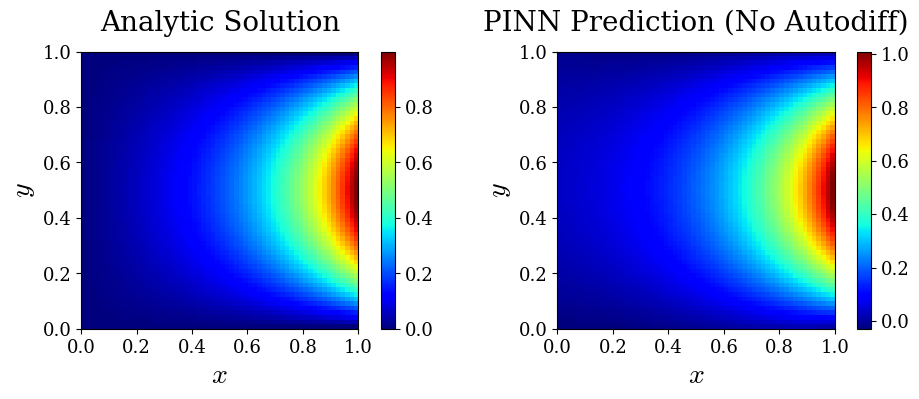

In [46]:
compare(PINN)

/tmp/ipykernel_382382/1894507987.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  abs_err = np.abs(u_pred_np - u_true)


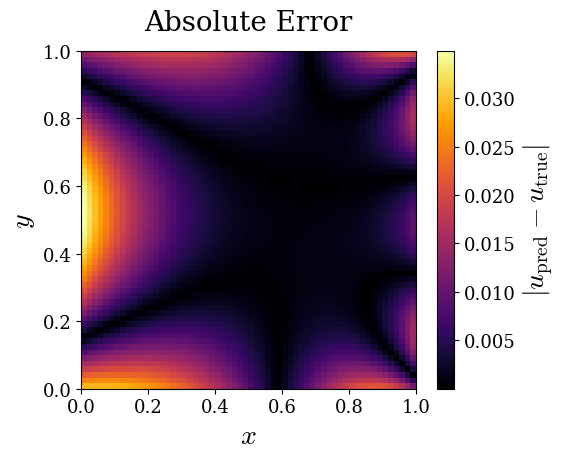

In [49]:
plt.rcParams.update({
    "font.size": 20,           # general text
     "axes.titlesize": 20,      
    "axes.labelsize": 20,      
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 20,



    "font.family": "serif",        # body text
    "mathtext.fontset": "cm",      # Computer Modern math
    "mathtext.rm": "serif",        # roman math -> serif
    "mathtext.it": "serif:italic",
    "mathtext.bf": "serif:bold",

})


x = torch.linspace(0,1,60).view(-1,1)
y = torch.linspace(0,1,60).view(-1,1)



    # if torch.is_tensor(x_test) != True:  
    #     x_test = torch.from_numpy(x_test)
    # if torch.is_tensor(y_test) != True:  
    #     y_test = torch.from_numpy(y_test)   


    # #convert to float
    # x = x_test.float()
    # y = y_test.float()    
    

    
x,y = torch.meshgrid(x.squeeze(),y.squeeze(), indexing = 'xy')

x = x.reshape(-1,1).to(device)     
y = y.reshape(-1,1).to(device) 


    # x_test = x_test.reshape(-1,1)     
    # y_test = y_test.reshape(-1,1) 


u_true = u_closed_form(x,y).reshape(60,60) 
u_true = u_true.cpu()


u_pred = PINN(x,y)

u_pred_np = u_pred.reshape(60,60).detach().cpu()


X = x.cpu()
Y = y.cpu()



abs_err = np.abs(u_pred_np - u_true)

# 2. Plot heatmap
plt.figure(figsize=(6,5))
im = plt.imshow(abs_err, 
                extent=[X.min(), X.max(), Y.min(), Y.max()], 
                origin='lower', cmap='inferno', aspect='auto')
plt.colorbar(im, label=r"$|u_{\mathrm{pred}} - u_{\mathrm{true}}|$")
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title("Absolute Error", pad = 15)
plt.tight_layout()
plt.savefig("laplace_abs_error.svg", format="svg", facecolor='none',
            transparent=True, bbox_inches="tight")
plt.show()
